In [64]:
!pip install lime

In [65]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import lime
from lime import lime_image
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.experimental_run_functions_eagerly(True)

In [2]:
%cd /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake
!ls

/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake
test  train  valid


In [3]:
img_direaltest = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real'
img_dirfaketest = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake'

img_direaltrain = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real'
img_dirfaketrain = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake'


img_direalval = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real'
img_dirfakeval = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake'

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
input_shape = (128,128,1)

In [5]:
realtest = os.listdir(img_direaltest)
realtrain = os.listdir(img_direaltrain)
realval = os.listdir(img_direalval)
faketest = os.listdir(img_dirfaketest)
faketrain = os.listdir(img_dirfaketrain)
fakeval = os.listdir(img_dirfakeval)



Reading Image

In [6]:
sum(np.array([len(realtest),len(realtrain),len(realval),len(faketest),len(faketrain),len(fakeval)]))

140000

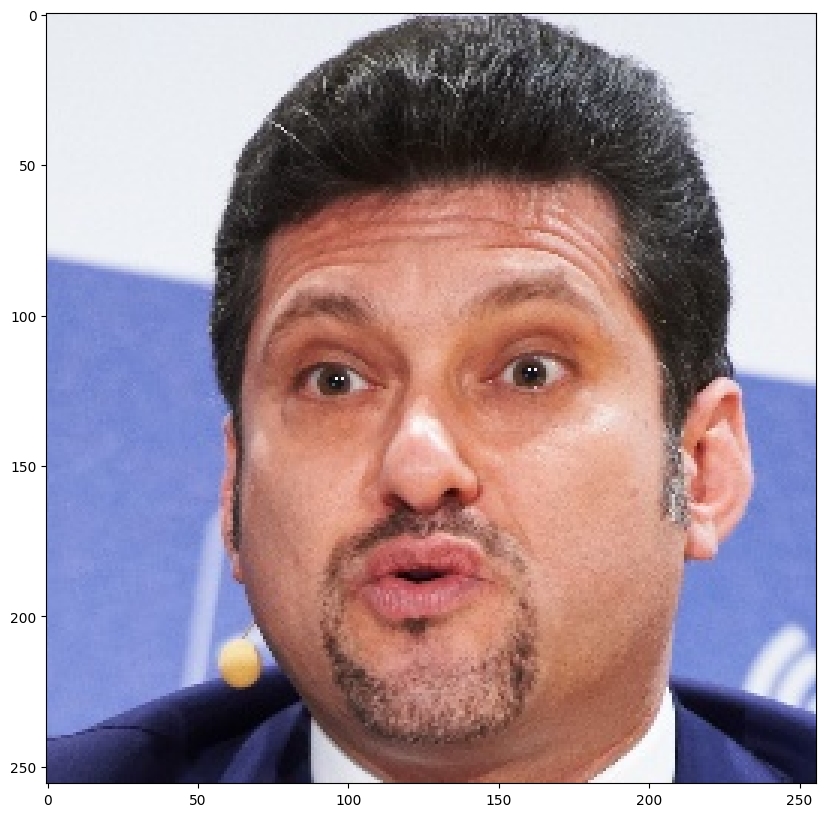

In [7]:
plt.figure(figsize = (14,10))
plt.imshow(plt.imread("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/"+pd.Series(realtest).astype(str)[123]))

In [8]:
realtestimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/"+pd.Series(realtest).astype(str)
faketestimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/"+pd.Series(faketest).astype(str)
realtrainimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/"+pd.Series(realtrain).astype(str)
faketrainimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake/"+pd.Series(faketrain).astype(str)
realvalimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/"+pd.Series(realval).astype(str)
fakevalimg = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/"+pd.Series(fakeval).astype(str)


In [9]:
series_images = pd.concat([realtestimg,faketestimg,realtrainimg,faketrainimg,realvalimg,fakevalimg])

In [10]:
series_images.shape

(140000,)

In [11]:
list_of_types = [np.repeat('real',len(realtest)),
np.repeat('fake',len(faketest)),
np.repeat('real',len(realtrain)),
np.repeat('fake',len(faketrain)),
np.repeat('real',len(realval)),
np.repeat('fake',len(fakeval))]


list_of_segmentation = [np.repeat('test',len(realtest)),
np.repeat('test',len(faketest)),
np.repeat('train',len(realtrain)),
np.repeat('train',len(faketrain)),
np.repeat('valid',len(realval)),
np.repeat('valid',len(fakeval))]

In [12]:
np.concatenate(list_of_types, axis=0).shape

(140000,)

In [13]:
list_of_typescon = np.concatenate(list_of_types, axis=0)
list_of_segmentationcon = np.concatenate(list_of_segmentation, axis=0)
list_of_segmentationcon

array(['test', 'test', 'test', ..., 'valid', 'valid', 'valid'],
      dtype='<U5')

In [14]:
df_imagesdfake = pd.DataFrame({'image_path':series_images,'img_status':list_of_typescon.tolist(),'where':list_of_segmentationcon.tolist()})
df_imagesdfake.shape

(140000, 3)

In [15]:
df_imagesdfake.head(4)

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,test
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,test
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,test
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,test


In [16]:
df_imagesdfake.value_counts("img_status")

img_status
fake    70000
real    70000
Name: count, dtype: int64

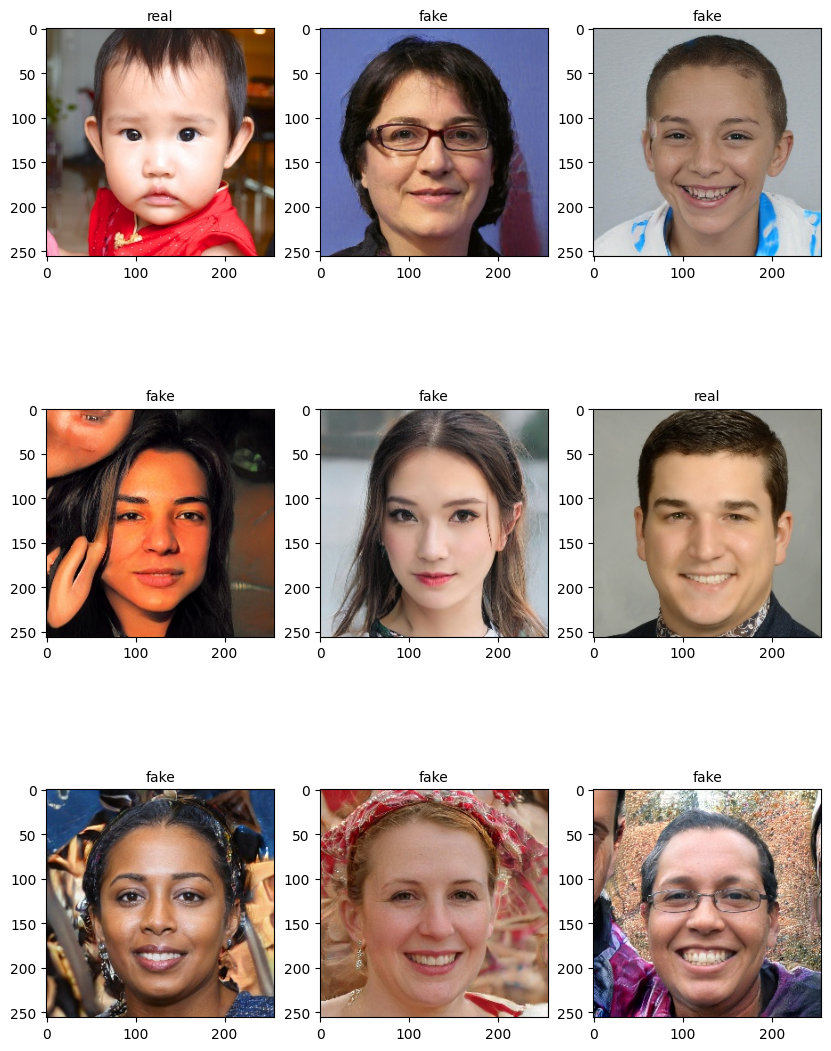

In [17]:
np.random.seed(42)
plt.figure(figsize = (10,14))

for i in range(9):
    random = np.random.randint(1,len(df_imagesdfake))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(df_imagesdfake['image_path'].iloc[random]))
    plt.title(df_imagesdfake['img_status'].iloc[random],size = 10)
    plt.xticks()
    plt.yticks()

plt.show()

In [21]:
datagen = ImageDataGenerator()

In [22]:
img_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

In [70]:
train_generator = datagen.flow_from_directory(img_dir+"train/",
                                             target_size = (128,128),
                                             batch_size = 100,
                                             color_mode = "rgb",
                                             class_mode = 'categorical')

Found 100000 images belonging to 2 classes.


In [71]:
valid_generator = datagen.flow_from_directory(img_dir+"valid/",
                                             target_size = (128,128),
                                             batch_size = 100,
                                             color_mode = "rgb",
                                             class_mode = 'categorical')

Found 20000 images belonging to 2 classes.


In [72]:
test_generator = datagen.flow_from_directory(img_dir+"valid/",
                                             target_size = (128,128),
                                             batch_size = 100,
                                             shuffle = False,
                                             color_mode = "rgb",
                                             class_mode = 'categorical')

Found 20000 images belonging to 2 classes.


Model

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation,BatchNormalization

In [127]:
def blockc(y,filt,kern):
    x = tf.keras.layers.Conv2D(filt,kern,padding = 'same')(y)
    x = tf.keras.layers.MaxPool2D(2, strides = 2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [128]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()

inp = tf.keras.layers.Input((128,128,3))
c0 = tf.keras.layers.Conv2D(4,3,padding = "same")(inp)
c0 = tf.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 = tf.keras.layers.GlobalAveragePooling2D()(c6)
c7 = tf.keras.layers.Flatten()(c6)
out = tf.keras.layers.Dense(2, activation = 'softmax')(c7)
model = tf.keras.Model(inputs = [inp],outputs = [out])


In [129]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [130]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64    

In [131]:
history = model.fit(
train_generator,
steps_per_epoch = 100000/1000,
validation_data = valid_generator,
validation_steps = (20000/1000),
epochs = 100)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 [==============================] - 44s 440ms/step - loss: 0.6674 - accuracy: 0.6089 - val_loss: 0.7059 - val_accuracy: 0.5345
Epoch 2/100
100/100 [==============================] - 40s 404ms/step - loss: 0.5722 - accuracy: 0.7013 - val_loss: 0.6370 - val_accuracy: 0.6450
Epoch 3/100
100/100 [==============================] - 41s 407ms/step - loss: 0.5068 - accuracy: 0.7525 - val_loss: 0.5205 - val_accuracy: 0.7480
Epoch 4/100
100/100 [==============================] - 41s 408ms/step - loss: 0.4613 - accuracy: 0.7802 - val_loss: 0.5868 - val_accuracy: 0.7185
Epoch 5/100
100/100 [==============================] - 38s 375ms/step - loss: 0.4276 - accuracy: 0.8052 - val_loss: 0.5266 - val_accuracy: 0.7440
Epoch 6/100
100/100 [==============================] - 40s 398ms/step - loss: 0.3955 - accuracy: 0.8216 - val_loss: 0.4793 - val_accuracy: 0.7800
Epoch 7/100
100/100 [==============================] - 39s 394ms/step - loss: 0.3601 - accuracy: 0.8411 - val_loss: 0.4541 - val_accurac

<Axes: >

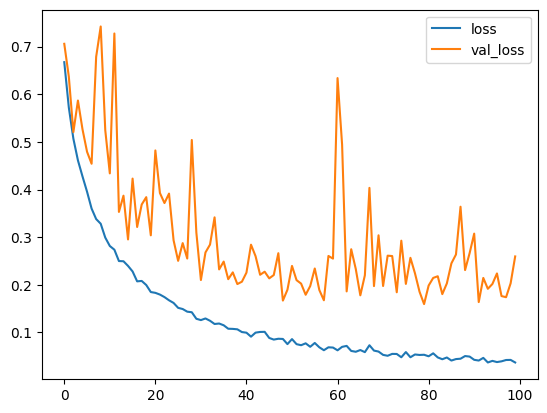

In [132]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

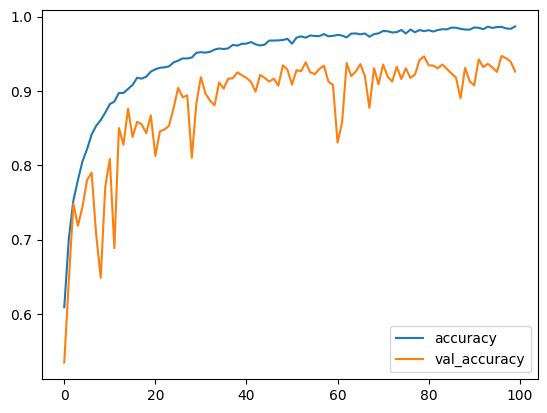

In [133]:
losses[['accuracy','val_accuracy']].plot()

In [134]:
#y_pred = model.predict(test_generator, verbose =1)
y_test = test_generator.classes

In [135]:
test_generator[0][1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [136]:

model.evaluate(test_generator[0][0],test_generator[0][1])

4/4 [==============================] - 0s 27ms/step - loss: 0.3930 - accuracy: 0.8800


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[0.39296475052833557, 0.8799999952316284]

In [137]:
explainer = lime_image.LimeImageExplainer()

In [138]:
test_generator[0][0][0].shape

(128, 128, 3)

In [139]:
import cv2

In [156]:
img = cv2.imread("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00XUQJZGHU.jpg")
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(128,128))
img = np.array(img)
data = img.reshape((128,128,3))
data.shape

(128, 128, 3)

In [157]:
test_generator[0][0][0].shape

(128, 128, 3)

In [158]:
model.predict(data.reshape(-1,128,128,3))

1/1 [==============================] - 0s 37ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[9.9980766e-01, 1.9240446e-04]], dtype=float32)

In [159]:
explanation = explainer.explain_instance(data, model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


(-0.5, 127.5, 127.5, -0.5)

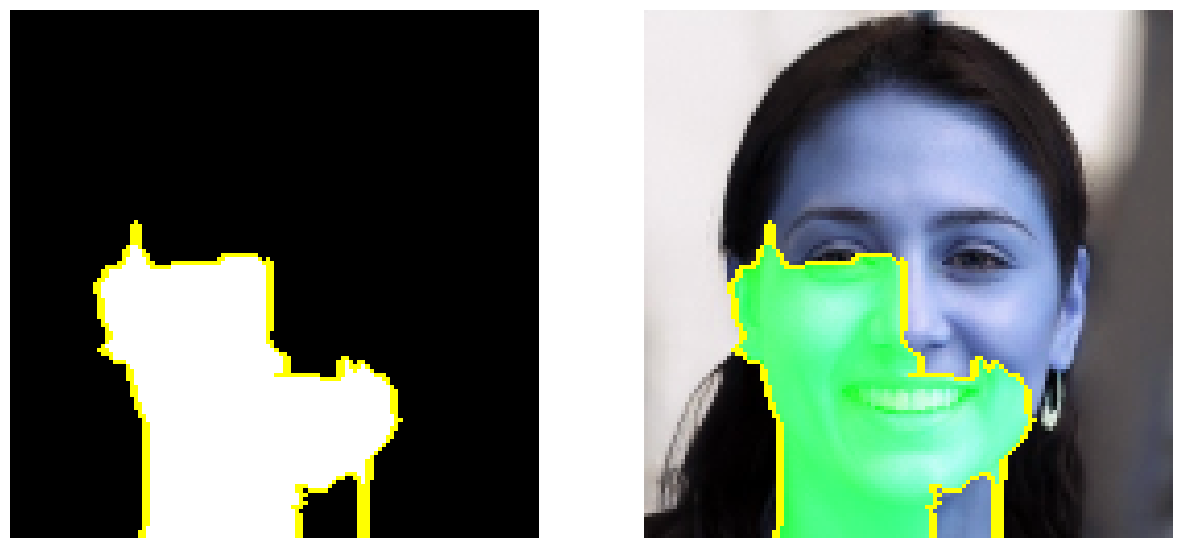

In [160]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [161]:
model.save("/kaggle/working/modelo/model_dfake-face_softmax.h5") 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#%cd /kaggle/working/my_usable_model/model_dfake-face
#!ls

In [ ]:
#!zip -r file.zip /kaggle/working/my_usable_model/model_dfake-face